<a href="https://colab.research.google.com/github/hanlululu/02807-Computational-tools-for-Data-Science/blob/main/Week4/slides_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02807 - Computational Tools for Data Science - Week 4

# Today
    
* More Pandas: 
    * `merge`/`join` for combining dataframes
    * `apply` and its many uses
* At-a-glance visualisations with the **Pandas profiler**
* **Static data visualisation** with Pandas and matplotlib
* **Supervised machine learning** for flower classification with **sklearn**
* **Interactive data visualisation** with plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# The University Ranking data


* Data from the Times Higher Education World University Ranking
* Started in the UK in 2010

In [ ]:
# Load data that we will use.
url = 'http://courses.compute.dtu.dk/02807/2021/lectures/week4/timesData.csv'
df_times = pd.read_csv(url)

In [ ]:
# information about df_times
df_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   world_rank              2603 non-null   object 
 1   university_name         2603 non-null   object 
 2   country                 2603 non-null   object 
 3   teaching                2603 non-null   float64
 4   international           2603 non-null   object 
 5   research                2603 non-null   float64
 6   citations               2603 non-null   float64
 7   income                  2603 non-null   object 
 8   total_score             2603 non-null   object 
 9   num_students            2544 non-null   object 
 10  student_staff_ratio     2544 non-null   float64
 11  international_students  2536 non-null   object 
 12  female_male_ratio       2370 non-null   object 
 13  year                    2603 non-null   int64  
dtypes: float64(4), int64(1), object(9)
memor

In [ ]:
df_times.year.value_counts().to_frame().T

,2016,2012,2015,2013,2014,2011
year,800,402,401,400,400,200


In [ ]:
df_times[df_times.year==2016].head(5)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
1803,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.2,"2,243",6.9,27%,33 : 67,2016
1804,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.2,"19,919",11.6,34%,46 : 54,2016
1805,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.9,"15,596",7.8,22%,42 : 58,2016
1806,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8,"18,812",11.8,34%,46 : 54,2016
1807,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,92.0,"11,074",9.0,33%,37 : 63,2016


# `apply` in pandas

The concept of `apply` is quite powerful in pandas, in particular when working with non numeric types. Here some slightly contrived examples, where we do string conversions on dataframes

In [ ]:
# The `female_male_ratio` is an object dtype, vectorisation benefits reduced
df_times.female_male_ratio.head()

0        NaN
1    33 : 67
2    37 : 63
3    42 : 58
4    45 : 55
Name: female_male_ratio, dtype: object

In [ ]:
# Convert ratio objects to float
def ratio_to_female_percentage(ratio):
    if pd.isnull(ratio):
        return np.nan

    female_ratio = ratio.split(':')[0].strip()
    # Some entries are listed as `-`
    if female_ratio.isnumeric():
        return float(female_ratio) / 100
    else:
        return np.nan

## Apply on a series

In [ ]:
df_times.female_male_ratio.apply(ratio_to_female_percentage)
# Could assign to new column, replace existing column, or its own variable

0        NaN
1       0.33
2       0.37
3       0.42
4       0.45
        ... 
2598    0.48
2599    0.36
2600     NaN
2601    0.28
2602    0.43
Name: female_male_ratio, Length: 2603, dtype: float64

Often pandas has built-in methods that help out. We could achieve the same using the code below.

In [ ]:
pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100

0        NaN
1       0.33
2       0.37
3       0.42
4       0.45
        ... 
2598    0.48
2599    0.36
2600     NaN
2601    0.28
2602    0.43
Name: female_male_ratio, Length: 2603, dtype: float64

In [ ]:
# Both methods give same series, otherwise this would produce AssertionError
pd.testing.assert_series_equal(
    df_times.female_male_ratio.apply(ratio_to_female_percentage),
    pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100
)

In [ ]:
%timeit df_times.female_male_ratio.apply(ratio_to_female_percentage)

1.19 ms ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100

1.51 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


While the reading material call the use of `Series.str` vectorisation, operating on strings this way is not guaranteed to give a performance boost of our code. 

* But it does make it **easier to read**!
* Strings are objects of variable size, so generally enabling vectorisation not possible

## Apply on dataframe

In [ ]:
def row_to_female_percentage(row):
    ratio = row.female_male_ratio
    female_percentage = ratio_to_female_percentage(ratio)
    
    # We can adjust computation based on other cell in this row
    # In this case we artificially boosts female_percentage for the US
    #   Note: This adjustment could be vectorised
    if row.country == 'United States of America':
        female_percentage *= 1.1
    
    return female_percentage

# Now apply to each row (by specifying axis=columns)
# Result is a series due to return type of the callback (row_to_female_percentage)
df_times.apply(row_to_female_percentage, axis='columns').head(10)

0      NaN
1    0.363
2    0.407
3    0.462
4    0.495
5    0.460
6    0.460
7    0.550
8    0.370
9    0.550
dtype: float64

## Apply on dataframe, create new dataframe

In [ ]:
def row_to_dataframe(row):
#     return pd.Series([row.country, row_to_female_percentage(row)])
    return pd.Series({'c': row.country, 'f': row_to_female_percentage(row)})

# Result is a dataframe due to returning a Series
df_times.head(10).apply(row_to_dataframe, axis='columns')

,c,f
0,United States of America,NaN
1,United States of America,0.363
2,United States of America,0.407
3,United States of America,0.462
4,United States of America,0.495
5,United Kingdom,0.460
6,United Kingdom,0.460
7,United States of America,0.550
8,United Kingdom,0.370
9,United States of America,0.550


# Merge/join - "column concatenation"

* `merge` (or its simpler sibling `join`) allow us to fuse together columns from two data frames into a single data frame. 
* We typically fuse based on some common value found in both data frames.

We create aggregate dataframes for two different years, where then `country` is a common value in both data frames

In [ ]:
country_teaching_2014 = df_times[df_times.year==2014].groupby('country').agg({'teaching': 'mean'})
country_teaching_2015 = df_times[df_times.year==2015].groupby('country').agg({'teaching': 'mean'})

In [ ]:
from IPython.display import display
display(country_teaching_2014.head(5), country_teaching_2015.head(5))

,teaching
country,
Australia,29.857895
Austria,28.450000
Belgium,33.142857
Brazil,44.250000
Canada,36.721053


,teaching
country,
Australia,32.320000
Austria,30.940000
Belgium,35.971429
Brazil,47.500000
Canada,38.983333


We first see the shape differ, and then which countries differ between the two years

In [ ]:
countries_differing = country_teaching_2014.index.union(country_teaching_2015.index) \
                      .difference(country_teaching_2014.index.intersection(country_teaching_2015.index))

country_teaching_2014.shape, country_teaching_2015.shape, countries_differing

((40, 1),
 (41, 1),
 Index(['Chile', 'Estonia', 'Macau', 'Morocco', 'Saudi Arabia'], dtype='object', name='country'))

Because there are such differences in country values, the type of fusion we do matter for the final result. Specifically, if a country only exists in one of the dataframes, what should happen to the values of that country?

In [ ]:
display(country_teaching_2014[country_teaching_2014.index.isin(countries_differing)],
        country_teaching_2015[country_teaching_2015.index.isin(countries_differing)])

,teaching
country,
Estonia,20.3
Saudi Arabia,19.8


,teaching
country,
Chile,13.0
Macau,17.1
Morocco,16.3


## Inner merge/join: Keep countries only if present in both

In [ ]:
country_teaching_inner = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='inner', left_index=True, right_index=True, suffixes=('_2014', '_2015'))

country_teaching_inner.shape

(38, 2)

## Left merge/join: Keep countries present in 2014 (left data frame)

In [ ]:
country_teaching_left = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='left', left_index=True, right_index=True, suffixes=('_2014', '_2015'))
# Shape of join is same as left data frame
country_teaching_left.shape

(40, 2)

## Right merge/join: Keep countries present in 2015 (right data frame)

In [ ]:
country_teaching_right = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='right', left_index=True, right_index=True, suffixes=('_2014', '_2015'))
# Shape of join is same as right data frame
country_teaching_right.shape

(41, 2)

## Outer merge/join: Keep countries present in either data frame

In [ ]:
country_teaching_outer = \
country_teaching_2014 \
    .merge(country_teaching_2015, how='outer', left_index=True, right_index=True, suffixes=('_2014', '_2015'))

country_teaching_outer.shape
# Shape of join as the union of the indices

(43, 2)

Except for inner join, the other join types leave us with empty values in one of the columns.

In [ ]:
# country_teaching_inner discards Chile, Macau, Morocco, Estonia, Saudi Arabia
# country_teaching_left discards Chile, Macau, Morocco
# country_teaching_right discards Estonia, Saudi Arabia
country_teaching_outer.loc[countries_differing]

,teaching_2014,teaching_2015
country,,
Chile,NaN,13.0
Estonia,20.3,NaN
Macau,NaN,17.1
Morocco,NaN,16.3
Saudi Arabia,19.8,NaN


# At-a-glance visualisations: the Pandas profiler

* Generally, EDA starts by df.describe(), df.info(), etc., done separately. 

* Recently, Pandas created an amazing open-source library called `pandas-profiling`.

* `pandas_profiling` offers interactive statistics with a single line of code.

In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(df_times, title="University Ranking dataset", html={'style': {'full_width': True}})

In [ ]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* But, often you'll still need your custom visualisation.
* Let's look into some tools for that.

# Static data visualisation with matplotlib (and a bit of seaborn)

* No moving parts, data as engineered into visualization.
* Light on resources: can visualise patterns in a large dataset.


## Bar charts

* Arguably, the simplest visualisation of categorical data

* Can be done using `matplotlib`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

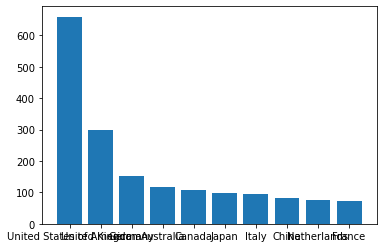

In [ ]:
_ = plt.bar(df_times['country'].value_counts().head(10).index.unique(), 
            df_times['country'].value_counts().head(10))

* Not satisfied with the looks, so we therefore explicitly create a figure/axis on which we call `bar` (now also adding a color argument)

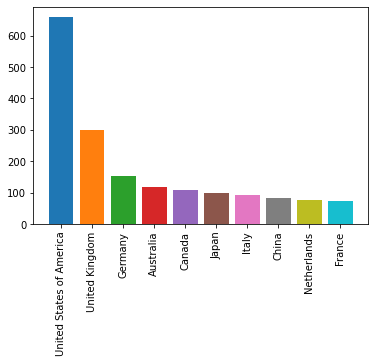

In [ ]:
fig, ax = plt.subplots()
ax.bar(df_times['country'].value_counts().head(10).index.unique(), 
       df_times['country'].value_counts().head(10),
       color=sns.color_palette())
ax.tick_params(axis='x', rotation=90)

* Matplotlib is a generic plotting tool, and sometimes it's overly cumbersome to get what you want. 
* Pandas improves on this (a bit), as it tries to infer from the DataFrame/Series object how it should be meaningfully plotted.
  * Typical pattern is index on the x-axis and columns on the y-axis
  * For most matplotlib plotting functions, an equivalent one exists on DataFrame or Series or both. These calls return an axis object we can further manipulate using matplotlib functions.
  * Pandas `plot` accepts a combination of matplotlib figure and axis arguments, but often we still need further layout adjustments for a pleasing result.
* In general, you should rely on pandas for initial plotting, then customize using matplotlib functions. 
    * This requires you to shape the dataframe you're given to match the type of plotting of interest. An operation you'd have to do anyway, before inputting the data to matplotlib

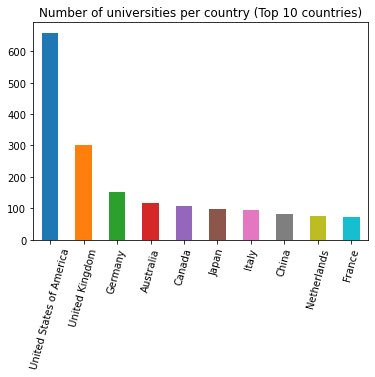

In [ ]:
# country becomes the index of value_counts() dataframe
ax_bar = df_times['country'].value_counts().head(10) \
              .plot(kind='bar', color=sns.color_palette(),
                    title='Number of universities per country (Top 10 countries)')
ax_bar.xaxis.set_tick_params(rotation=75)

## Activating seaborn

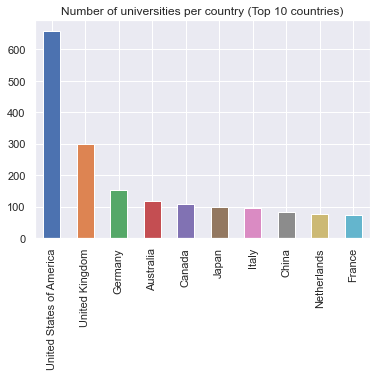

In [ ]:
sns.set() # Now activated with seaborn defaults for future plotting
_ = df_times['country'].value_counts().head(10) \
              .plot(kind='bar', color=sns.color_palette(),
                    title='Number of universities per country (Top 10 countries)')

## More on bar charts and subplots

In [ ]:
df_times_mean_by_year = df_times.groupby('year').mean()
df_times_mean_by_year.head()

,teaching,research,citations,student_staff_ratio
year,,,,
2011,54.756500,55.457500,71.589500,15.949485
2012,37.838060,35.884577,57.287065,17.990698
2013,41.683000,40.777500,65.268000,18.413882
2014,37.270000,35.562750,66.536750,18.543990
2015,38.370823,37.202743,68.483791,18.705641


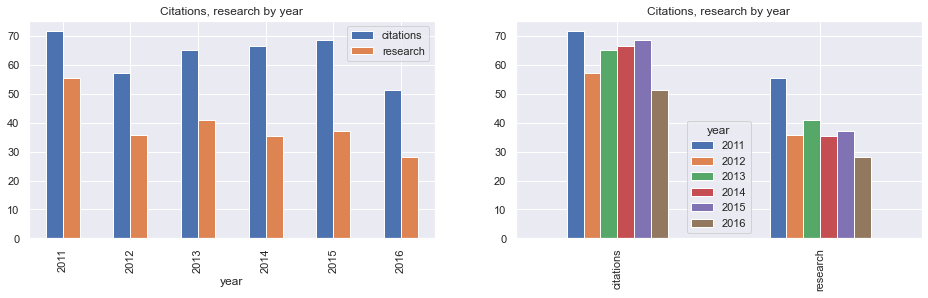

In [ ]:
# Defines a 1 row, 2 columns grid which we use by specifying `ax` argument when plotting
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

# Plots by index, groups are different columns, illustrated by taking transpose in second subplot
df_times_mean_by_year[['citations', 'research']] \
    .plot.bar(color=sns.color_palette(), ax=axarr[0], title='Citations, research by year')

_ = df_times_mean_by_year[['citations', 'research']].T \
    .plot.bar(color=sns.color_palette(), ax=axarr[1], title='Citations, research by year')

## Line charts

* Bar charts work fine for a small number of categories

* When looking at changes over time, line charts may be more appropriate.

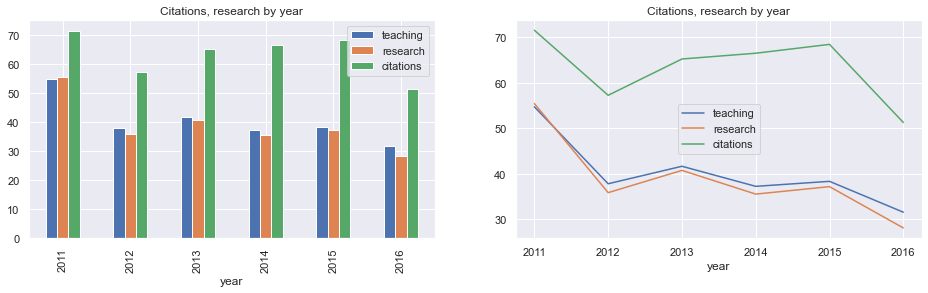

In [ ]:
# Defines a 1 row, 2 columns grid which we use by specifying `ax` argument when plotting
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

# Plots by index, groups are explicitly named
df_times_mean_by_year.plot.bar(y=['teaching', 'research', 'citations'], 
                                color=sns.color_palette(), ax=axarr[0], title='Citations, research by year')

_ = df_times_mean_by_year.plot.line(y=['teaching', 'research', 'citations'],
                                color=sns.color_palette(), ax=axarr[1], title='Citations, research by year')

In [ ]:
times_international_students = df_times['international_students']

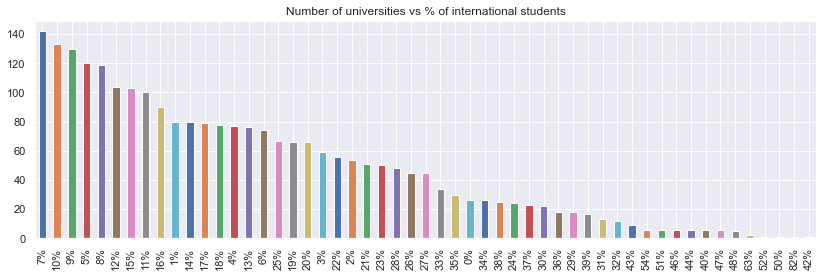

In [ ]:
# Bar chart gets cluttered
_ =  times_international_students.value_counts() \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Number of universities vs % of international students')

Don't mislead yourself by using line charts like this

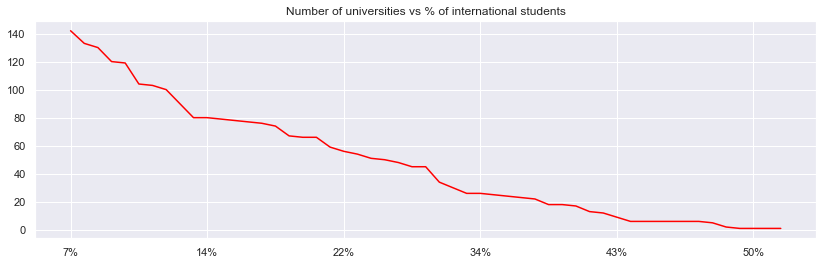

In [ ]:
# Line chart could make more sense, but obfuscates that x-axis isn't actually ordered!
_ = times_international_students.value_counts() \
              .plot(kind='line', color='red', figsize=(14, 4),
                    title='Number of universities vs % of international students')

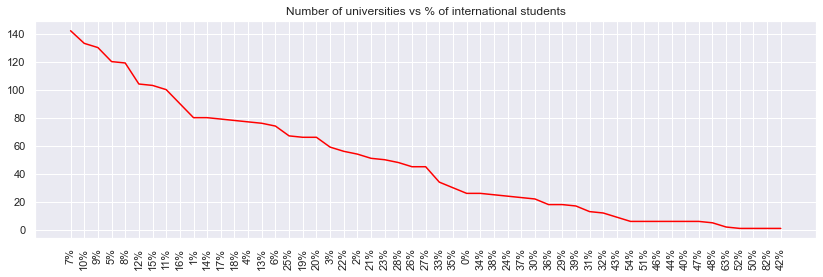

In [ ]:
# Now the chart looks less dense without obfuscation, but information isn't really improved
times_international_students.value_counts() \
              .plot(kind='line', color='red', figsize=(14, 4),
                    title='Number of universities vs % of international students')
_ = plt.xticks(np.arange(len(times_international_students.value_counts().index)), 
               times_international_students.value_counts().index, rotation=90)

* Neither bar charts nor line charts really capture this relationship well

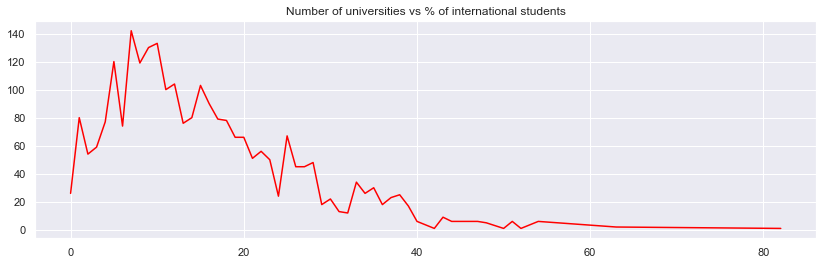

In [ ]:
# Creating new column where percentage is float rather than string
df_times['international_students_float'] = times_international_students.str.replace('%', '').astype(float)
# Sorting by index prior to plotting gives us an non-obfuscated x-axis
_ = df_times['international_students_float'].value_counts().sort_index() \
              .plot(kind='line', color='red', figsize=(14, 4),
                    title='Number of universities vs % of international students')


## Histograms

* For illustrating frequency of a variable, histograms may be more appropriate than bar/line charts

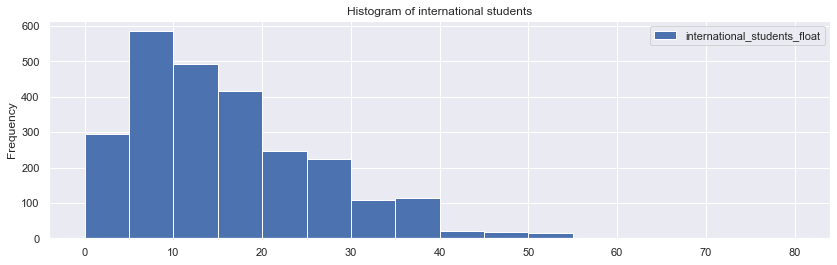

In [ ]:
# Works on numerical data for its binning
_ = df_times[['international_students_float']] \
          .plot.hist(bins=16, range=[0, 16*5],
                     title='Histogram of international students', figsize=(14, 4))

## Scatter plots

* When looking at samples with paired numerical data, scatter plots illustrate this relationship

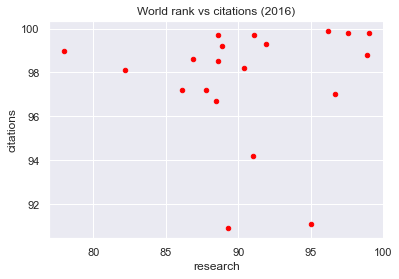

In [ ]:
# Observe the x and y axis are different ranges which can be misleading
ax = df_times[df_times.year==2016].head(20) \
           .plot(kind='scatter', x='research', y='citations',
                 color='red', title='World rank vs citations (2016)')

# To correct set the x and y limits explicitly
# ax.set_xlim([80, 101])
# _ = ax.set_ylim([80, 101])

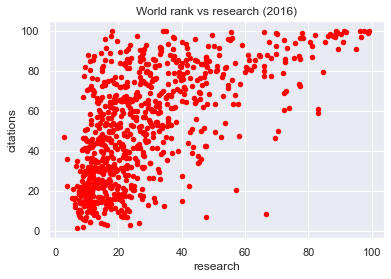

In [ ]:
_ = df_times[df_times.year==2016] \
           .plot(kind='scatter', x='research', y='citations',
                 color='red', title='World rank vs research (2016)')

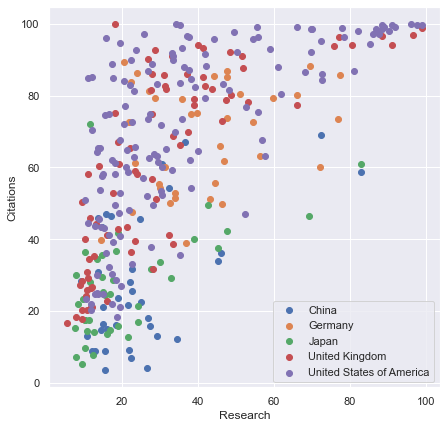

In [ ]:
# Scatter plot with coloring by country
fig, ax = plt.subplots(figsize=(6, 6))

df_times_by_country = df_times[df_times.year == 2016] \
                        .groupby(['country']) \
                        .filter(lambda g: len(g) > 35)

# Filter produces a subset of original DataFrame, on which we groupby again
for group, df_group in df_times_by_country.groupby(['country']):
    ax.scatter(df_group.research, df_group.citations, label=group)

ax.set_xlabel('Research')
ax.set_ylabel('Citations')
fig.set_size_inches(7, 7)
_ = ax.legend()

This shows you can have a high citation value with low research value, but rarely the other way round.

### Correlation: NY Hotels

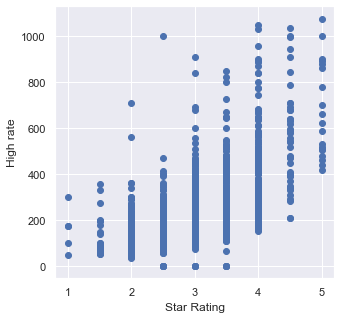

In [ ]:
url = 'https://raw.githubusercontent.com/s-heisler/pycon2017-optimizing-pandas/master/pyCon%20materials/new_york_hotels.csv'
df_ny = pd.read_csv(url, encoding='cp1252')
# Plotting high rate against star rating shows an expected trend (though it's not a great plot)
fig, ax = plt.subplots(figsize=(5, 5))
# Removing elements above the 98-percentile
df_ny_rates = df_ny[df_ny.high_rate < df_ny.high_rate.quantile(0.98)]
ax.scatter(df_ny_rates.star_rating, df_ny_rates.high_rate)

ax.set_xlabel('Star Rating')
_ = ax.set_ylabel('High rate')

The sample Pearson correlation coefficient over paired samples $\{ (x_1,y_1),\ldots,(x_n,y_n) \}$ is given by

$r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$

where:

* $n$ is sample size
* $x_i, y_i$ are the individual sample points indexed with $i$
* $\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$ (is the sample mean); and analogously for $\bar{y}$

Interpretation

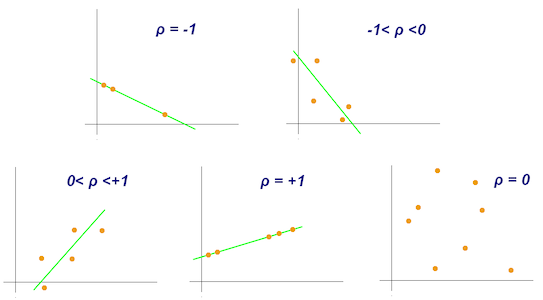

In [ ]:
# Here pairing is done over rows, so each row represents a sample in the above equation
df_ny[['star_rating', 'high_rate']].sample(6)

,star_rating,high_rate
1202,2.5,169.3300
944,4.0,649.2200
554,2.0,148.6222
1280,3.5,140.1800
62,2.5,169.3500
1097,2.5,109.7600


In [ ]:
# What's the sample correlation r_{xy}?
col1 = df_ny['star_rating']
col2 = df_ny['high_rate']
col1.corr(col2)

0.4578312614942432

In [ ]:
# Compute it for all pairs of columns
df_ny.corr()

,ean_hotel_id,latitude,longitude,star_rating,high_rate,low_rate
ean_hotel_id,1.000000,-0.105138,0.045289,0.065347,-0.009524,0.031447
latitude,-0.105138,1.000000,-0.574376,-0.369289,-0.231536,-0.253724
longitude,0.045289,-0.574376,1.000000,0.244953,0.152842,0.178270
star_rating,0.065347,-0.369289,0.244953,1.000000,0.457831,0.441211
high_rate,-0.009524,-0.231536,0.152842,0.457831,1.000000,0.765325
low_rate,0.031447,-0.253724,0.178270,0.441211,0.765325,1.000000


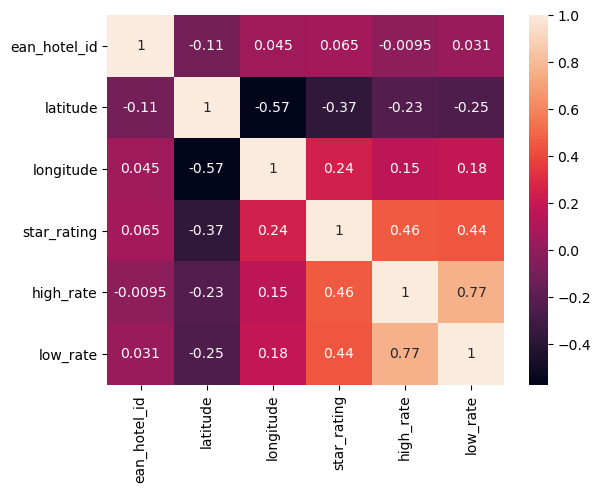

In [ ]:
# Get a heat-map visualisation of the correlation matrix, that is,
# the correlation between all pairs of columns
# It's a symmetric matrix with 1's in the diagonal

sns.heatmap(df_ny.corr(), annot=True)
plt.show()

## Box plots

In [ ]:
# In effect any world_rank >= 200 becomes NaN
# requires data imputation for meaningful plotting
df_times_by_country['world_rank_float'] = \
        pd.to_numeric(df_times_by_country.world_rank, errors='coerce').dropna()

ax = df_times_by_country.groupby('country').boxplot(
                    subplots=False, 
                    column=['world_rank_float'], 
                    rot=45,
                    figsize=(8, 4))
_ = ax.set_title('Per country world_rank box plots (2016)')

## Date Plotting - data types sometimes matter

* Under the hood matplotlib and pandas try to derive sane configurations to display your data
* It can sometimes be necessary to correct data types, so these educated guesses are correct

In [ ]:
df_times['year_datetime'] = pd.to_datetime(df_times.year, format="%Y")

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

_ = df_times['year'].value_counts().plot.line( 
                              color=sns.color_palette(),
                              title='Wrongly ordered line plot',
                              ax=axarr[0], rot=45)

_ = df_times['year_datetime'].value_counts().plot.line( 
                              color=sns.color_palette(),
                              title='Correctly ordered line plot',
                              ax=axarr[1], rot=45)


## Plotting rules of thumbs

Remember to always include
* Titles and names of axes
* Legend (when applicable)
* Readable ticks (labels on x and y axis)
* Discernable coloring of different variables/categories
* A brief summary of what is plotted, possibly followed by bulleted observations discernable from the plot.

[Rules of thumb for visualization](https://www.beyondtheboxscore.com/2011/1/7/1920544/rules-of-thumb-for-visualization)

* Know Your Story: Consider exactly what you want to convey in your chart.
* Pick an Appropriate Graph Type: Bar or Line charts typically fine options, careful with pie charts.
* Don't Overdo It: Don't try to encapsulate all your data in a single chart, just because it's possible.
* Focus the Message: Keep (and emphasize) only chart elements that tell your story
* Add Color (where appropriate)
* Resist the Urge to Pretty-up the Graph with Chart Junk

Reducing clutter is a non-trivial task, but consider some of these options to alleviate the issue:

* Aggregate data points prior to plotting, or use fewer (sampled) data points.
    * Sometimes your data is simply to massive or multi-facetted to be charted all at once, don't let that ruin the story.
* "Zoom in": View smaller portion of data points (e.g. only 2016)
* Split into multiple plots for different categories (careful, as 10x more plots don't necessarily improve the story)
* Reduce dot size and use alpha (transparency) or hues in scatter plots




# Basics of machine learning with sklearn

* Machine learning is a huge field
* We'll just do a "hello world" of machine learning: a supervised learning (classification) task with `sklearn`


## Iris dataset: classify iris plants into three species

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> Iris setosa, Iris versicolor, and Iris virginica </td></tr>
</table>

* Classic dataset! Can be found on the UCI Machine Learning Repository.

* It includes three iris species with 50 samples each as well as some properties about each flower.

* The species are:
  * Iris setosa
  * Iris virginica
  * Iris versicolor


* The columns in this dataset are:
  * Id
  * SepalLengthCm
  * SepalWidthCm
  * PetalLengthCm
  * PetalWidthCm
  * Species

* The goal is to predict the species (target) based on the sepal and petal measurements (features).

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
new_names = ['sepal_length','sepal_width','petal_length','petal_width','iris_class']
dataset = pd.read_csv(url, names=new_names, skiprows=0, delimiter=',')
dataset.info()

Let's have a look at the data.

In [ ]:
dataset.head(5)

In [ ]:
dataset.groupby('iris_class').count()

Let's split the data into input features ($x$) and target class ($y$). 

In [ ]:
# target labels
y_data = dataset['iris_class']
# input features
x_data = dataset.drop(['iris_class'], axis=1)

print ("dataset : ",dataset.shape)
print ("x : ", x_data.shape)
print ("y : ", y_data.shape)

## Encoding categorical variables

* We'll use a neural network to solve this classification task.

* Neural networks require all input and output variables to be numeric.

* Our targets / labels are categorical at the moment.

* We have to encode our labels into numbers before you can train our model: Each categorical variable is converted to 0, 1 or 2. This indicates a sample has exactly one class.

In [ ]:
# Factor encoding of target 
y, uniques = pd.factorize(y_data)
y, uniques

* Below we use a simple train/test split as our form of model validation; i.e. as a test to validate how our neural network model performs.
* Train set: Data which is shown to your model, from which you hope it learns valuable information that generalize to unseen samples.
    * Given large enough models and enough training time, models can learn to perform perfectly on train set.
* Test set: Data used to evaluate your model, which you hope mimics the data your models would see "in the wild".
    * A perfect classifier on the Train set may have overfit the data and not perform well on your test set.
* Roughly speaking, train set performance is "irrelevant" and test set performance (best case) informs us how well the model generalizes
    * Cross-validation is a more elaborate technique for model validation

In [ ]:
from sklearn.model_selection import train_test_split

# generate training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.3)

# converting to float 64bit
x_train = np.array(x_train).astype(np.float64)
x_test  = np.array(x_test).astype(np.float64)
y_train = np.array(y_train).astype(np.float64)
y_test  = np.array(y_test).astype(np.float64)

# data split
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
x_train[:2], y_train[:2]

## Define and train model

We'll use `sklearn`'s `MLPClassifier, which implements a multi-layer perceptron (MLP) network that trains using backpropagation.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

We'll use an MLP with 3 hidden layers, each with 10 units.

In [ ]:
# model initialisation
lr = LogisticRegression(multi_class='ovr')
mlp_small = MLPClassifier(hidden_layer_sizes=(3, 7, 3), max_iter=1000, verbose=1)
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, verbose=1)

Let's train the model. In `sklearn`, the `fit function is used to train a machine learning model on the data.

In [ ]:
# train our model
lr.fit(x_train, y_train)
mlp_small.fit(x_train, y_train)
mlp.fit(x_train, y_train)

## Model predictions

And look at the predictions.

In [ ]:
# use our model to predict
y_pred_lr = lr.predict(x_test)
y_pred_small = mlp_small.predict(x_test)
y_pred = mlp.predict(x_test)

In [ ]:
y_pred_lr[:6], y_pred_small[:6], y_pred[:6], y_test[:6]

We can also get the predictions out as a per-class probability. To get a single prediction, `predict` selects the entry with highest `proba` value (as `argmax` below). 

In [ ]:
mlp.predict_proba(x_test)[:6], mlp.predict_proba(x_test)[:6].argmax(axis=1)

## Model validation

* Accuracy on the test set is one way to evaluate the performance of the model.
* To evaluate a model, some other commonly used concepts are the confusion matrix, precision, recall, and f1 score. 
* The `confusion_matrix` and `classification_report` methods of the `sklearn` metrics library offers these scores.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
print("Logistic Regression - Classification report:\n", classification_report(y_test, y_pred_lr))
print("\nMLP (Small) - Classification report:\n", classification_report(y_test, y_pred_small))
print("\nMLP - Classification report:\n", classification_report(y_test, y_pred))

In [ ]:
# Reset some seaborn layout changes
from matplotlib import rc_file_defaults
rc_file_defaults()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

_ = plot_confusion_matrix(lr, x_test, y_test, display_labels=uniques, cmap=plt.cm.Blues, ax=ax[0])
_ = plot_confusion_matrix(mlp_small, x_test, y_test, display_labels=uniques, cmap=plt.cm.Blues, ax=ax[1])
_ = plot_confusion_matrix(mlp, x_test, y_test, display_labels=uniques, cmap=plt.cm.Blues, ax=ax[2])

## GPU acceleration on Colab

* When training machine learning models, you can often speed-up your code with GPUs.
* Change the runtime type of your Colab notebook and you'll get connected to a GPU for free!

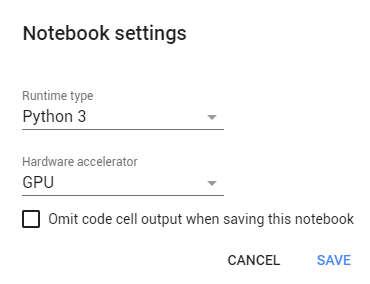

# Practical take-away

* Pandas has easy-to-use, in-built plotting functionality, based on matplotlib. Fine for static visualisation.
* For interactive visualisation, look elsewhere. Plotly is nice, but there's more: bokeh, pygal, etc.
* Interactive visualisation is often useful, but it's resource-intensive. Use accordingly.
* For at-a-glance, interactive statistics, use the Pandas profiling library.
* sklearn can be used for machine learning tasks. It offers many types of models (decision trees, nearest neighbors, neural nets) and is easy to use.
* There's much more to machine learning that we can't cover. Feel free to go down the rabbit hole! 
* Deep learning Python libraries: tensorflow, keras, pytorch, etc. For a very high-level library, there's e.g. fastai.


# Interactive data visualisation with Plotly (Self-study)



* Visualisations based off Kaggle notebooks. 

* Dynamic:

  * various operations on the data: zooming, panning, hovering over a data point, etc.
  * great for inspecting data in detail
  * resource-intensive: interactive graphics are much, much more resource-intensive than static ones.


In [ ]:
# There's more recent versions of plotly, using this for demonstration 
!pip install plotly==3.10.0

In [ ]:
# for rendering plotly in Colab
# see https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
# plotly
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

## Line Charts


In [ ]:
configure_plotly_browser_state() # add this line to see plotly plots in Colab

# prepare data frame
df = df_times.iloc[:100,:]

# import graph objects as "go"
import plotly.graph_objs as go

# Creating trace1
trace1 = go.Scatter(
                    x = df.world_rank,
                    y = df.citations,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    text= df.university_name)
# Creating trace2
trace2 = go.Scatter(
                    x = df.world_rank,
                    y = df.teaching,
                    mode = "lines+markers",
                    name = "teaching",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),
                    text= df.university_name)
# Creating trace3
trace3 = go.Scatter(
                    x = df.world_rank,
                    y = df.female_male_ratio.apply(lambda r: r.split(':')[0] if not pd.isnull(r) else np.nan),
                    mode = "lines+markers",
                    name = "female_ratio",
                    marker = dict(color = 'rgba(26, 26, 150, 0.8)'),
                    text= df.university_name)
data = [trace1, trace2, trace3]
layout = dict(title = 'Citation and Teaching vs World Rank of Top 100 Universities',
              xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

## Scatter plots


In [ ]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:100,:]
df2015 = df_times[df_times.year == 2015].iloc[:100,:]
df2016 = df_times[df_times.year == 2016].iloc[:100,:]
# import graph objects as "go"
import plotly.graph_objs as go
# creating trace1
trace1 =go.Scatter(
                    x = df2014.world_rank,
                    y = df2014.citations,
                    mode = "markers",
                    name = "2014",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= df2014.university_name)
# creating trace2
trace2 =go.Scatter(
                    x = df2015.world_rank,
                    y = df2015.citations,
                    mode = "markers",
                    name = "2015",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= df2015.university_name)
# creating trace3
trace3 =go.Scatter(
                    x = df2016.world_rank,
                    y = df2016.citations,
                    mode = "markers",
                    name = "2016",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= df2016.university_name)
data = [trace1, trace2, trace3]
layout = dict(title = 'Citation vs world rank of top 100 universities with 2014, 2015 and 2016 years',
              xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Citation',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

## Bar charts (example 1)


In [ ]:
# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
df2014

In [ ]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
# import graph objects as "go"
import plotly.graph_objs as go
# create trace1 
trace1 = go.Bar(
                x = df2014.university_name,
                y = df2014.citations,
                name = "citations",
                marker = dict(color = 'rgba(50, 10, 250, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df2014.country)
# create trace2 
trace2 = go.Bar(
                x = df2014.university_name,
                y = df2014.teaching,
                name = "teaching",
                marker = dict(color = 'rgba(25, 215, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df2014.country)
data = [trace1, trace2]

layout = {
  'xaxis': {'title': 'Top 3 universities in 2014 (citations and teaching)'},
  'barmode': 'group',
  'title': 'citations and teaching of the top 3 universities in 2014'
};
fig = go.Figure(data = data, layout = layout)
iplot(fig)

## Bar charts (example 2)

* If we change the barmode from *group* to *relative* in the previous example, we get the following. 
* The code bellow illustrates a different syntax for traces.


In [ ]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
# import graph objects as "go"
import plotly.graph_objs as go

x = df2014.university_name

trace1 = {
  'x': x,
  'y': df2014.citations,
  'name': 'citation',
  'type': 'bar'
}
trace2 = {
  'x': x,
  'y': df2014.teaching,
  'name': 'teaching',
  'type': 'bar'
}
data = [trace1, trace2];
layout = {
  'xaxis': {'title': 'Top 3 universities in 2014 (citations and teaching)'},
  'barmode': 'relative',
  'title': 'citations and teaching of the top 3 universities in 2014'
}
fig = go.Figure(data = data, layout = layout)
iplot(fig)

## Mixing chart types

* We can also see several charts side by side
* Example: Horizontal bar charts next to scatter plots
* Below: citation vs income for universities

In [ ]:
configure_plotly_browser_state()

# import graph objects as "go" and import tools
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
# prepare data frames
df2016 = df_times[df_times.year == 2016].iloc[:7,:]

y_saving = [each for each in df2016.research]
y_net_worth  = [float(each) for each in df2016.income]
x_saving = [each for each in df2016.university_name]
x_net_worth  = [each for each in df2016.university_name]
trace0 = go.Bar(
                x=y_saving,
                y=x_saving,
                marker=dict(color='rgba(171, 50, 96, 0.6)',line=dict(color='rgba(171, 50, 96, 1.0)',width=1)),
                name='research',
                orientation='h',
)
trace1 = go.Scatter(
                x=y_net_worth,
                y=x_net_worth,
                mode='lines+markers',
                line=dict(color='rgb(63, 72, 204)'),
                name='income',
)
layout = dict(
                title='Citations and income of the top 6 universities in 2016',
                yaxis=dict(showticklabels=True,domain=[0, 0.85]),
                yaxis2=dict(showline=True,showticklabels=False,linecolor='rgba(102, 102, 102, 0.8)',linewidth=2,domain=[0, 0.85]),
                xaxis=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0, 0.42]),
                xaxis2=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0.47, 1],side='top',dtick=25),
                legend=dict(x=0.029,y=1.038,font=dict(size=10) ),
                margin=dict(l=200, r=20,t=70,b=70),
                paper_bgcolor='rgb(248, 248, 255)',
                plot_bgcolor='rgb(248, 248, 255)',
)
annotations = []
y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)
# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=ydn - 4,text='{:,}'.format(ydn),font=dict(family='Arial', size=12,color='rgb(63, 72, 204)'),showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1', y=xd, x=yd + 3,text=str(yd),font=dict(family='Arial', size=12,color='rgb(171, 50, 96)'),showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
iplot(fig)

## Bubble Charts 

* Basic bubble chart: three-dimensional data. 
* Like a scatter plot, where the third dimension is given by bubble size. 
* Can more dimensions using colors, for example.

Example with 4 dimensions:
*  University world rank (first 20 of 2016) vs teaching score
*  number of students (size of bubble)
*  internationalisation score (color)


In [ ]:
configure_plotly_browser_state()

# data preparation
df2016 = df_times[df_times.year == 2016].iloc[:20,:]
num_students_size  = [float(each.replace(',', '.')) for each in df2016.num_students]
international_color = [float(each) for each in df2016.international]
data = [
    {
        'y': df2016.teaching,
        'x': df2016.world_rank,
        'mode': 'markers',
        'marker': {
            'color': international_color,
            'size': num_students_size,
            'showscale': True
        },
        "text" :  df2016.university_name
    }
]
iplot(data)

## Box Plots (example of statistical chart)

* A standardized way of displaying the distribution of data.

* The ends of the box represent the lower and upper quartiles, while the median is marked by a line inside the box. 

* Median (50th percentile) = middle value of the data set. 

* 25th percentile = quartile 1 (Q1) that is lower quartile

* 75th percentile = quartile 3 (Q3) that is higher quartile

* height of box = IQR = interquartile range = Q3-Q1

* Outliers =  more than 1.5*IQR away from median commonly.
      

In [ ]:
configure_plotly_browser_state()

# data preparation
x2015 = df_times[df_times.year == 2015]

trace0 = go.Box(
    y=x2015.total_score,
    name = 'total score of universities in 2015',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace1 = go.Box(
    y=x2015.research,
    name = 'research of universities in 2015',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace0, trace1]
iplot(data)

## Multiple Subplots

* Useful for comparing more than one features.



In [ ]:
configure_plotly_browser_state()

trace1 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.research,
    name = "research"
)
trace2 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.citations,
    xaxis='x2',
    yaxis='y2',
    name = "citations"
)
trace3 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.income,
    xaxis='x3',
    yaxis='y3',
    name = "income"
)
trace4 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.total_score,
    xaxis='x4',
    yaxis='y4',
    name = "total_score"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 0.45]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    xaxis3=dict(
        domain=[0, 0.45],
        anchor='y3'
    ),
    xaxis4=dict(
        domain=[0.55, 1],
        anchor='y4'
    ),
    yaxis2=dict(
        domain=[0, 0.45],
        anchor='x2'
    ),
    yaxis3=dict(
        domain=[0.55, 1]
    ),
    yaxis4=dict(
        domain=[0.55, 1],
        anchor='x4'
    ),
    title = 'Research, citation, income and total score vs World Rank of Universities (2015)'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)